**Multi-GPU working**  
https://www.kaggle.com/code/rasmus01610/notebook-multi-gpu-training-with-pytorch-lightning/notebook

In [1]:
import os
import PIL
import torch
import numpy as np

#from monai.data import DataLoader, ArrayDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR, CyclicLR, StepLR
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

import torchvision.transforms.functional as TF
import random
from typing import Sequence

import glob
import os

from torch.utils.data import random_split
import lightning as pl
from torch import optim
from sklearn.metrics import accuracy_score

pl.seed_everything(7)

Seed set to 7


7

In [2]:
import torchvision.transforms.functional as TF
import random
from typing import Sequence

class RotateTransform:
    def __init__(self, angles: Sequence[int]):
        self.angles = angles
        self.count = 0

    def __call__(self, x):
        angle = random.choice(self.angles)
        self.count += 1
        if self.count%500 == 0:
            pass
            #print(self.count, angle)
        if angle == 0:
            return x
        else:
            return TF.rotate(x, angle)

In [3]:
batch_size = 128
n_gpu = 4
lr = 1e-1
#lr = 1e-4
n_epoch = 400
weight_decay = 2e-05

In [4]:
class PCBModel(pl.LightningModule):
    def __init__(self, net, lr, loss):
        super().__init__()
        self.net = net
        self.lr = lr
        self.loss = loss 
        
    def forward(self, x):
        return torch.nn.functional.softmax(self.net(x), dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        #loss = self.loss(y_hat, y.float())
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        #val_acc = (y.argmax(dim=1) == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        val_acc = (y == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        self.log("val_acc", val_acc, prog_bar=True, sync_dist=True)
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        #return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        acc = (y == y_hat.argmax(dim=1)).float().sum() / y.shape[0]
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
        
    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        #scheduler = CosineAnnealingLR(optimizer, self.trainer.max_epochs * 200, 0)
        #scheduler = CyclicLR(optimizer, base_lr=self.lr/100, max_lr=self.lr, step_size_up = 100)
        #print('n_train = ', self.n_train)
        #print('batch_size = ', batch_size)
        #print('max_epochs = ', self.trainer.max_epochs)
        #total_steps = self.n_train//batch_size//n_gpu
        total_steps = 20
        '''
        scheduler = OneCycleLR(optimizer, max_lr=self.lr,
                               #epochs=self.trainer.max_epochs//4,
                               total_steps = total_steps
                               #epochs=1,
                               #steps_per_epoch=self.n_train//batch_size//n_gpu
                              )
        '''
        scheduler = StepLR(optimizer, 
                           step_size = n_epoch//8,
                           gamma = 0.5,
                           #epochs=1,
                           #steps_per_epoch=self.n_train//batch_size//n_gpu
                          )
        return [optimizer], [scheduler]

    def setup(self, stage=None):
        path = "./PCB_data"

        train_transforms = transforms.Compose(
            [
                transforms.Resize((224,224)),
                #transforms.RandomHorizontalFlip(),  # 좌우반전 
                #RotateTransform([0,90,180,270]),
                #transforms.RandomVerticalFlip(),  # 상하반전 
                #transforms.RandomVerticalFlip(),  # 상하반전 
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
            ]
        )
        
        test_transforms = transforms.Compose(
            [
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
            ]
        )
        
        # choose the training and test datasets
        self.train_ds = datasets.ImageFolder(path, train_transforms)
        self.val_test_ds = datasets.ImageFolder(path, test_transforms)

        
        n_data = len(self.train_ds)
        n_train = int(n_data*0.9)
        self.n_train = n_train
        import numpy as np
        np.random.seed(42)
        perm = np.random.permutation(n_data)
        self.train_indices = perm[:n_train]
        self.val_indices = perm[n_train:]
        self.test_indices = perm[n_train:]

        self.train_ds = Subset(self.train_ds, self.train_indices)
        self.val_ds = Subset(self.val_test_ds, self.val_indices)
        self.test_ds = Subset(self.val_test_ds, self.test_indices)

        #self.val_sampler = SubsetRandomSampler(val_indices)
        #self.test_sampler = SubsetRandomSampler(test_indices)
        
    def train_dataloader(self):
        #self.train_sampler = SubsetRandomSampler(np.random.permutation(self.train_indices))
        #return DataLoader(self.train_ds, pin_memory=True, num_workers=2, batch_size=batch_size, sampler=self.train_sampler)
        return DataLoader(self.train_ds, pin_memory=True, num_workers=2, batch_size=batch_size, shuffle=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds, pin_memory=True, num_workers=2, batch_size=batch_size, shuffle=False)
        
    def test_dataloader(self):
        #return DataLoader(self.test_ds, pin_memory=True, num_workers=2, batch_size=batch_size, sampler=self.test_sampler)
        return DataLoader(self.test_ds, pin_memory=True, num_workers=2, batch_size=batch_size, shuffle=False)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat.argmax(dim=1)
        
    def predict_dataloader(self):
        return DataLoader(self.val_ds, pin_memory=True, num_workers=2, batch_size=batch_size, shuffle=False)
        

In [5]:
#pretrained = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
#pretrained = models.resnet152(pretrained=False)
pretrained = models.resnet50(pretrained=False)
pretrained

/home/kotech/venv-lightning/lib/python3.8/site-packages/torchvision/models/_utils.py:208: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
/home/kotech/venv-lightning/lib/python3.8/site-packages/torchvision/models/_utils.py:223: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
num_classes = 2
num_ftrs = pretrained.fc.in_features
pretrained.fc = torch.nn.Linear(num_ftrs, num_classes)

In [7]:
net = pretrained
loss = torch.nn.CrossEntropyLoss()
model = PCBModel(net, lr, loss)

In [8]:
checkpoint_callback = ModelCheckpoint(monitor='val_acc', dirpath='./ckpt', mode='max', verbose=True)
trainer = pl.Trainer(accelerator="gpu",
                     devices=n_gpu,
                     strategy="ddp_notebook",
                     callbacks=[
                         LearningRateMonitor(logging_interval="step"),
                         checkpoint_callback,
                     ],
                     #logger=pl.pytorch.loggers.CSVLogger(save_dir='./'),
                     max_epochs=n_epoch, log_every_n_steps=40)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kotech/venv-lightning/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
log_dir = trainer.logger.log_dir
#trainer.fit(model, train_dl, val_dl)
trainer.fit(model)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/

Sanity Checking: |                                                                                            …

/home/kotech/venv-lightning/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=40). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 23: 'val_acc' reached 0.77978 (best 0.77978), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=0-step=23-v3.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 1, global step 46: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 2, global step 69: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 3, global step 92: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 4, global step 115: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 5, global step 138: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 6, global step 161: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 7, global step 184: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 8, global step 207: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 9, global step 230: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 10, global step 253: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 11, global step 276: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 12, global step 299: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 13, global step 322: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 14, global step 345: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 15, global step 368: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 16, global step 391: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 17, global step 414: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 18, global step 437: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 19, global step 460: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 20, global step 483: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 21, global step 506: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 22, global step 529: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 23, global step 552: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 24, global step 575: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 25, global step 598: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 26, global step 621: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 27, global step 644: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 28, global step 667: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 29, global step 690: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 30, global step 713: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 31, global step 736: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 32, global step 759: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 33, global step 782: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 34, global step 805: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 35, global step 828: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 36, global step 851: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 37, global step 874: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 38, global step 897: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 39, global step 920: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 40, global step 943: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 41, global step 966: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 42, global step 989: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 43, global step 1012: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 44, global step 1035: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 45, global step 1058: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 46, global step 1081: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 47, global step 1104: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 48, global step 1127: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 49, global step 1150: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 50, global step 1173: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 51, global step 1196: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 52, global step 1219: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 53, global step 1242: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 54, global step 1265: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 55, global step 1288: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 56, global step 1311: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 57, global step 1334: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 58, global step 1357: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 59, global step 1380: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 60, global step 1403: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 61, global step 1426: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 62, global step 1449: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 63, global step 1472: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 64, global step 1495: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 65, global step 1518: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 66, global step 1541: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 67, global step 1564: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 68, global step 1587: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 69, global step 1610: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 70, global step 1633: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 71, global step 1656: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 72, global step 1679: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 73, global step 1702: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 74, global step 1725: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 75, global step 1748: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 76, global step 1771: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 77, global step 1794: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 78, global step 1817: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 79, global step 1840: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 80, global step 1863: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 81, global step 1886: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 82, global step 1909: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 83, global step 1932: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 84, global step 1955: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 85, global step 1978: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 86, global step 2001: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 87, global step 2024: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 88, global step 2047: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 89, global step 2070: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 90, global step 2093: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 91, global step 2116: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 92, global step 2139: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 93, global step 2162: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 94, global step 2185: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 95, global step 2208: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 96, global step 2231: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 97, global step 2254: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 98, global step 2277: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 99, global step 2300: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 100, global step 2323: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 101, global step 2346: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 102, global step 2369: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 103, global step 2392: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 104, global step 2415: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 105, global step 2438: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 106, global step 2461: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 107, global step 2484: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 108, global step 2507: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 109, global step 2530: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 110, global step 2553: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 111, global step 2576: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 112, global step 2599: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 113, global step 2622: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 114, global step 2645: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 115, global step 2668: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 116, global step 2691: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 117, global step 2714: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 118, global step 2737: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 119, global step 2760: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 120, global step 2783: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 121, global step 2806: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 122, global step 2829: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 123, global step 2852: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 124, global step 2875: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 125, global step 2898: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 126, global step 2921: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 127, global step 2944: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 128, global step 2967: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 129, global step 2990: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 130, global step 3013: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 131, global step 3036: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 132, global step 3059: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 133, global step 3082: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 134, global step 3105: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 135, global step 3128: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 136, global step 3151: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 137, global step 3174: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 138, global step 3197: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 139, global step 3220: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 140, global step 3243: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 141, global step 3266: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 142, global step 3289: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 143, global step 3312: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 144, global step 3335: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 145, global step 3358: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 146, global step 3381: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 147, global step 3404: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 148, global step 3427: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 149, global step 3450: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 150, global step 3473: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 151, global step 3496: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 152, global step 3519: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 153, global step 3542: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 154, global step 3565: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 155, global step 3588: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 156, global step 3611: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 157, global step 3634: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 158, global step 3657: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 159, global step 3680: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 160, global step 3703: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 161, global step 3726: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 162, global step 3749: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 163, global step 3772: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 164, global step 3795: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 165, global step 3818: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 166, global step 3841: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 167, global step 3864: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 168, global step 3887: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 169, global step 3910: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 170, global step 3933: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 171, global step 3956: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 172, global step 3979: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 173, global step 4002: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 174, global step 4025: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 175, global step 4048: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 176, global step 4071: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 177, global step 4094: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 178, global step 4117: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 179, global step 4140: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 180, global step 4163: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 181, global step 4186: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 182, global step 4209: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 183, global step 4232: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 184, global step 4255: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 185, global step 4278: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 186, global step 4301: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 187, global step 4324: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 188, global step 4347: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 189, global step 4370: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 190, global step 4393: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 191, global step 4416: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 192, global step 4439: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 193, global step 4462: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 194, global step 4485: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 195, global step 4508: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 196, global step 4531: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 197, global step 4554: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 198, global step 4577: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 199, global step 4600: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 200, global step 4623: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 201, global step 4646: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 202, global step 4669: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 203, global step 4692: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 204, global step 4715: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 205, global step 4738: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 206, global step 4761: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 207, global step 4784: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 208, global step 4807: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 209, global step 4830: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 210, global step 4853: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 211, global step 4876: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 212, global step 4899: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 213, global step 4922: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 214, global step 4945: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 215, global step 4968: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 216, global step 4991: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 217, global step 5014: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 218, global step 5037: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 219, global step 5060: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 220, global step 5083: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 221, global step 5106: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 222, global step 5129: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 223, global step 5152: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 224, global step 5175: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 225, global step 5198: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 226, global step 5221: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 227, global step 5244: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 228, global step 5267: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 229, global step 5290: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 230, global step 5313: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 231, global step 5336: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 232, global step 5359: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 233, global step 5382: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 234, global step 5405: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 235, global step 5428: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 236, global step 5451: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 237, global step 5474: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 238, global step 5497: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 239, global step 5520: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 240, global step 5543: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 241, global step 5566: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 242, global step 5589: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 243, global step 5612: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 244, global step 5635: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 245, global step 5658: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 246, global step 5681: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 247, global step 5704: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 248, global step 5727: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 249, global step 5750: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 250, global step 5773: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 251, global step 5796: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 252, global step 5819: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 253, global step 5842: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 254, global step 5865: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 255, global step 5888: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 256, global step 5911: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 257, global step 5934: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 258, global step 5957: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 259, global step 5980: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 260, global step 6003: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 261, global step 6026: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 262, global step 6049: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 263, global step 6072: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 264, global step 6095: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 265, global step 6118: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 266, global step 6141: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 267, global step 6164: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 268, global step 6187: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 269, global step 6210: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 270, global step 6233: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 271, global step 6256: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 272, global step 6279: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 273, global step 6302: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 274, global step 6325: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 275, global step 6348: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 276, global step 6371: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 277, global step 6394: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 278, global step 6417: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 279, global step 6440: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 280, global step 6463: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 281, global step 6486: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 282, global step 6509: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 283, global step 6532: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 284, global step 6555: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 285, global step 6578: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 286, global step 6601: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 287, global step 6624: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 288, global step 6647: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 289, global step 6670: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 290, global step 6693: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 291, global step 6716: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 292, global step 6739: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 293, global step 6762: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 294, global step 6785: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 295, global step 6808: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 296, global step 6831: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 297, global step 6854: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 298, global step 6877: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 299, global step 6900: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 300, global step 6923: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 301, global step 6946: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 302, global step 6969: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 303, global step 6992: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 304, global step 7015: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 305, global step 7038: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 306, global step 7061: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 307, global step 7084: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 308, global step 7107: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 309, global step 7130: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 310, global step 7153: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 311, global step 7176: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 312, global step 7199: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 313, global step 7222: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 314, global step 7245: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 315, global step 7268: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 316, global step 7291: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 317, global step 7314: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 318, global step 7337: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 319, global step 7360: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 320, global step 7383: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 321, global step 7406: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 322, global step 7429: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 323, global step 7452: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 324, global step 7475: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 325, global step 7498: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 326, global step 7521: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 327, global step 7544: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 328, global step 7567: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 329, global step 7590: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 330, global step 7613: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 331, global step 7636: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 332, global step 7659: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 333, global step 7682: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 334, global step 7705: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 335, global step 7728: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 336, global step 7751: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 337, global step 7774: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 338, global step 7797: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 339, global step 7820: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 340, global step 7843: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 341, global step 7866: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 342, global step 7889: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 343, global step 7912: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 344, global step 7935: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 345, global step 7958: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 346, global step 7981: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 347, global step 8004: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 348, global step 8027: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 349, global step 8050: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 350, global step 8073: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 351, global step 8096: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 352, global step 8119: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 353, global step 8142: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 354, global step 8165: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 355, global step 8188: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 356, global step 8211: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 357, global step 8234: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 358, global step 8257: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 359, global step 8280: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 360, global step 8303: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 361, global step 8326: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 362, global step 8349: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 363, global step 8372: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 364, global step 8395: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 365, global step 8418: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 366, global step 8441: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 367, global step 8464: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 368, global step 8487: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 369, global step 8510: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 370, global step 8533: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 371, global step 8556: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 372, global step 8579: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 373, global step 8602: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 374, global step 8625: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 375, global step 8648: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 376, global step 8671: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 377, global step 8694: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 378, global step 8717: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 379, global step 8740: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 380, global step 8763: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 381, global step 8786: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 382, global step 8809: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 383, global step 8832: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 384, global step 8855: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 385, global step 8878: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 386, global step 8901: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 387, global step 8924: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 388, global step 8947: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 389, global step 8970: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 390, global step 8993: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 391, global step 9016: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 392, global step 9039: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 393, global step 9062: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 394, global step 9085: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 395, global step 9108: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 396, global step 9131: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 397, global step 9154: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 398, global step 9177: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 399, global step 9200: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=400` reached.


In [10]:
ckpt_path =checkpoint_callback.best_model_path 
ckpt_path

'/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=1-step=180-v4.ckpt'

In [11]:
#trainer.test(model, ckpt_path=checkpoint_callback.best_model_path)

In [12]:
#del model
#torch.cuda.empty_cache()

In [13]:
#trainer.test(model, ckpt_path=checkpoint_callback.best_model_path)
#model = PCBModel.load_from_checkpoint(checkpoint_callback.best_model_path, net=net, lr=lr, loss=loss)
#trainer.test(model)

In [14]:
trainer_pre = pl.Trainer(accelerator="gpu",
                     devices=1,
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kotech/venv-lightning/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [15]:
y_pred = trainer_pre.predict(model, return_predictions=True)
y_pred = torch.cat(y_pred).numpy()

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                               | 0/? [00:00<?, ?i…

In [53]:
img_name, y_true = zip(*model.val_test_ds.imgs)
img_name = np.array(list(img_name))
y_true = np.array(list(y_true))
img_name = img_name[model.val_indices]
y_true = y_true[model.val_indices]

# accuracy
acc = (y_true == y_pred).sum()/len(y_pred)
print('accuracy =', acc)

accuracy = 0.9349529780564263


accuracy_score: 0.9349529780564263
              precision    recall  f1-score   support

           0     0.9569    0.9598    0.9584       995
           1     0.8561    0.8470    0.8515       281

    accuracy                         0.9350      1276
   macro avg     0.9065    0.9034    0.9049      1276
weighted avg     0.9347    0.9350    0.9348      1276



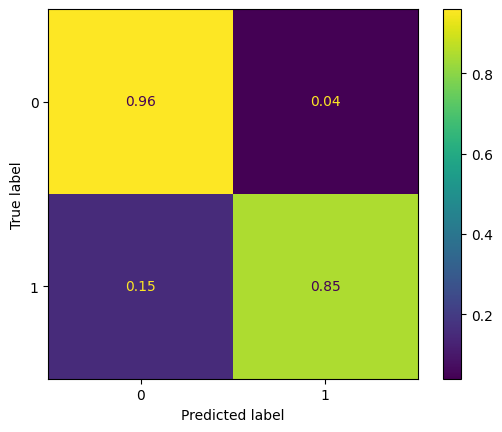

In [56]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print('accuracy_score:', accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
c = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

In [10]:
trainer.logger.log_dir

'/home/kotech/workspace/webstudy/deep/lightning/lightning_logs/version_66'

In [10]:
import pandas as pd
import seaborn as sn

,lr-Adam,train_loss,val_acc,val_loss
epoch,,,,
0.0,NaN,NaN,0.779781,0.533481
0.0,0.1,NaN,NaN,NaN
1.0,NaN,0.469512,NaN,NaN
1.0,NaN,NaN,0.779781,0.533481
2.0,NaN,NaN,0.779781,0.533481


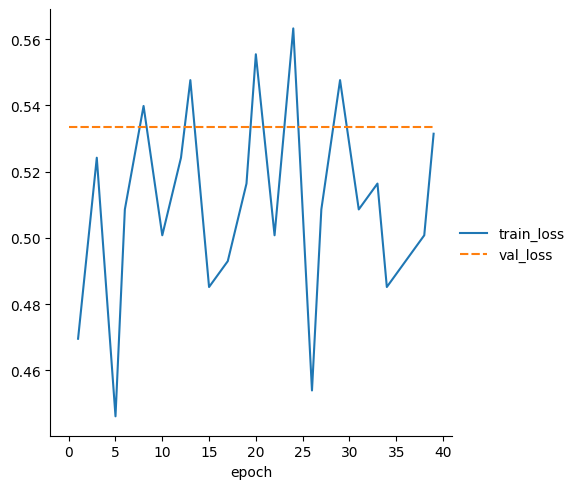

In [12]:
df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

last_epoch = 0
for index, row in df.iterrows():
    if not np.isnan(row['epoch']):
        last_epoch = row['epoch']
    else:
        df.at[index, 'epoch'] = last_epoch
        
del df["step"]
df.set_index("epoch", inplace=True)
display(df.dropna(axis=1, how="all").head())
sn.relplot(data=df[['train_loss','val_loss']], kind="line")
#sn.relplot(data=df[['val_loss']], kind="line")

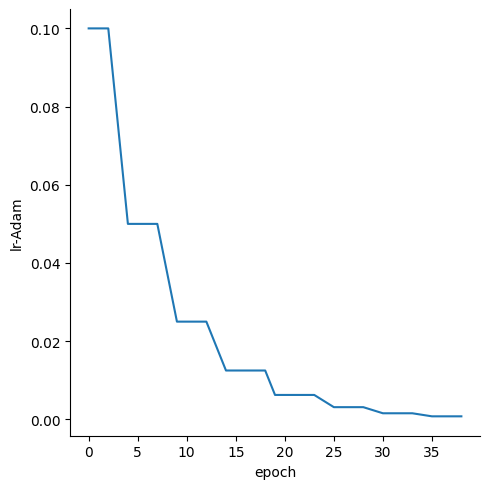

In [13]:
sn.relplot(data=df['lr-Adam'], kind="line")

In [17]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,lr-Adam,step,train_loss,val_acc,val_loss
0,NaN,0.000100,39,NaN,NaN,NaN
1,0.0,NaN,39,0.479822,NaN,NaN
2,NaN,0.000100,79,NaN,NaN,NaN
3,0.0,NaN,79,0.420152,NaN,NaN
4,0.0,NaN,89,NaN,0.921630,0.389038
...,...,...,...,...,...,...
105,NaN,0.000013,1759,NaN,NaN,NaN
106,19.0,NaN,1759,0.316813,NaN,NaN
107,NaN,0.000013,1799,NaN,NaN,NaN
108,19.0,NaN,1799,0.316653,NaN,NaN


In [17]:
y_pred.shape

AttributeError: 'NoneType' object has no attribute 'shape'

/tmp/ipykernel_1450777/4113246361.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)


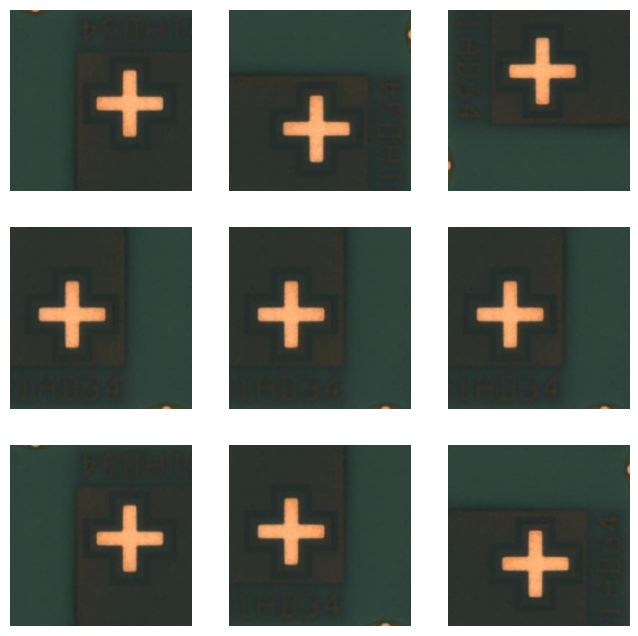

In [17]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torchvision.transforms.functional import to_pil_image

def pil_to_tensor(pil_image):
    # PIL: [width, height]
    # -> NumPy: [width, height, channel]
    # -> Tensor: [channel, width, height]
    return torch.as_tensor(np.asarray(pil_image)).permute(2,0,1)

def tensor_to_pil(tensor_image):
    return to_pil_image(tensor_image)

def tensor_to_pltimg(tensor_image):
    return tensor_image.permute(1,2,0).numpy()

## 여기를 바꿔가며 확인
transform = RotateTransform([0,90,180,270])
#######



image_path = 'PCB_data/OK/DF0.jpg'
plt.figure(figsize=(8, 8))
for i in range(9):
    pil_image = PIL.Image.open(image_path)
    tensor = pil_to_tensor(pil_image)
    applied_image = transform(tensor)
    
    plt.subplot(3, 3, i+1)
    plt.imshow(tensor_to_pltimg(applied_image))
    plt.axis("off")
plt.show()

In [19]:
tensor[0].shape

torch.Size([250, 250])

In [24]:
model.setup()

In [25]:
model.val_ds

In [26]:
path = "./PCB_data"

train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # 좌우반전 
        RotateTransform([0,90,180,270]),
        #transforms.RandomVerticalFlip(),  # 상하반전 
        transforms.RandomVerticalFlip(),  # 상하반전 
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #  정규화(normalization)
    ]
)

val_test_ds = datasets.ImageFolder(path, test_transforms)

AttributeError: 'Subset' object has no attribute 'imgs'